In [11]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import random
import os
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
import numpy as np
import torch
from custom_transformers import *
import tensorflow as tf
import sys
sys.path.append('..')  

from augmentation_generator_batch_size import *

## Efficient Net on Random Pixels

In [12]:
def seed_everything(seed: int=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(51)

### Load data

In [13]:
cifar10 = tf.keras.datasets.cifar10

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")

X_train.shape: (50000, 32, 32, 3) 
Y_train.shape: (50000, 1) 
X_test.shape: (10000, 32, 32, 3) 
Y_test.shape: (10000, 1)


In [16]:
random_pixels_cutout = RandomPixelCutout(max_cutout_size=0.05, color=True)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

train_gen = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32,
    augmentor=random_pixels_cutout, augment_fraction=0.2, overwrite=False)

test_gen = AugmentedCIFAR10Generator(X_test, Y_test,
    batch_size=32, shuffle=False, augmentor=None)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_gen, validation_data=test_gen, epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 732s 388ms/step - accuracy: 0.5020 - loss: 1.4065 - val_accuracy: 0.6872 - val_loss: 0.9001
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 713s 380ms/step - accuracy: 0.5959 - loss: 1.1377 - val_accuracy: 0.7013 - val_loss: 0.8616
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 709s 378ms/step - accuracy: 0.6097 - loss: 1.1038 - val_accuracy: 0.7161 - val_loss: 0.8312
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 708s 378ms/step - accuracy: 0.6181 - loss: 1.0772 - val_accuracy: 0.7198 - val_loss: 0.8113
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 709s 378ms/step - accuracy: 0.6230 - loss: 1.0690 - val_accuracy: 0.7317 - val_loss: 0.8023
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 709s 378ms/step - accuracy: 0.6222 - loss: 1.0737 - val_accuracy: 0.6913 - val_loss: 0.8581
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 708s 378ms/step - accuracy: 0.6071 - loss: 1.1323 - val_accuracy: 0.6546 - val_loss: 0.9499
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 702s 374ms/step - ac

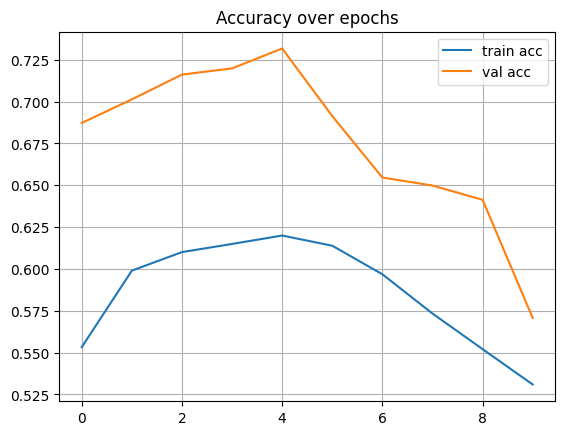

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy over epochs")
plt.grid(True)
plt.show()

In [18]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Accuracy on test set: {test_acc:.2%}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 119s 379ms/step - accuracy: 0.5708 - loss: 2.1502
Accuracy on test set: 57.07%


Results on new model are not satifying, after 5th epoch accuracy starts to fall but even at epoch 5 test core is around 70% which is not enough.